# Boosting factor of many halos

In [8]:
from prettyfigure.style import *

%matplotlib inline
from colossus.Cosmology import *
from colossus.HaloConcentration import *
from colossus.HaloDensityProfile import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import betainc

from dmb.single_halo import *
from dmb.mass_func import *

define_figure_style()
setCosmology('planck13')
cosmo = getCurrent()

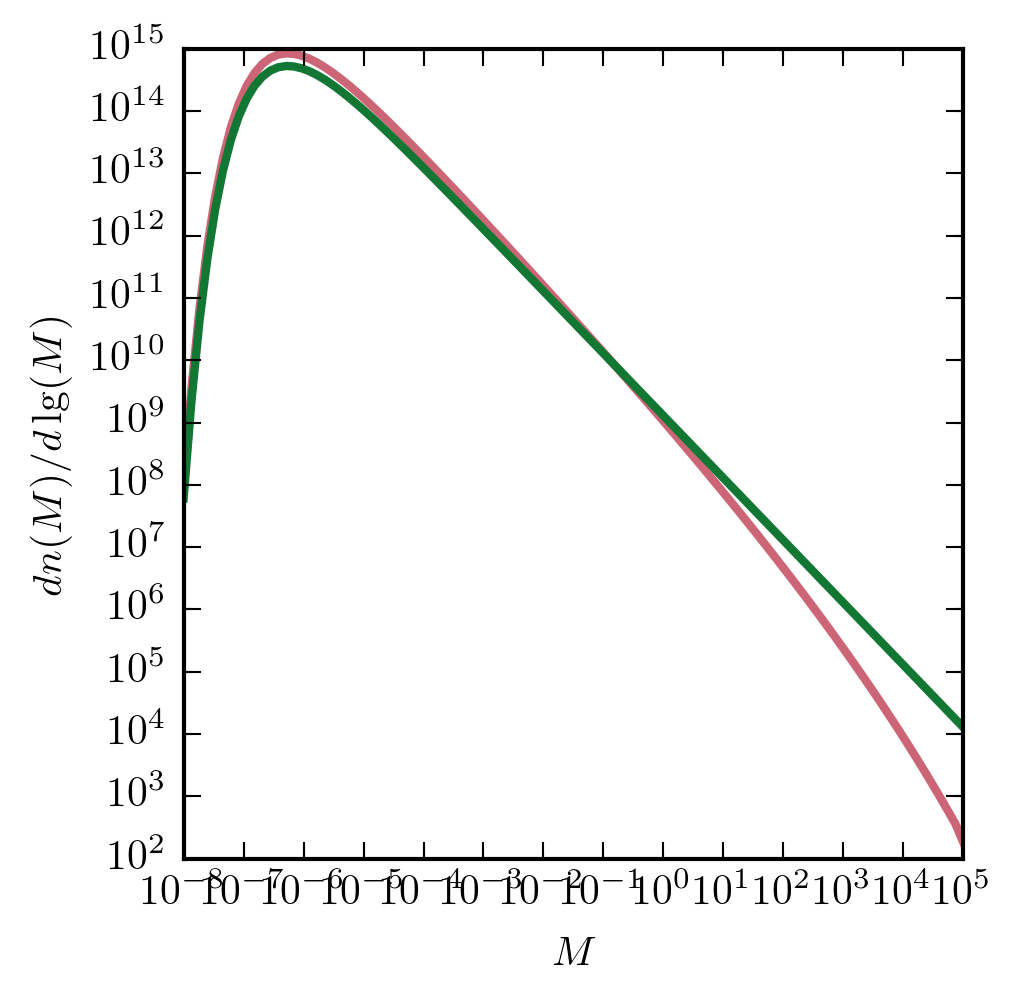

In [9]:
z = 26.0
M_list = np.logspace(-8, 5, 1e2)

def myPS(M, Mcut, z, cosmo):
    '''
    My implementation of PS mass function
    :param M: mass
    :param z: redshift
    :param cosmo: cosmology
    :return:
    '''
    deltac = Cosmology.AST_delta_collapse
    R = cosmo.lagrangianR(M)
    sigma = cosmo.sigma(R, j=0, z=z)
    Rup = cosmo.lagrangianR(M*1.01)
    Rdw = cosmo.lagrangianR(M/1.01)
    dsigmadM = - (cosmo.sigma(Rup, j=0, z=z) - cosmo.sigma(Rdw, j=0, z=z)) / (0.02 * M)
    dndM = np.sqrt(2/np.pi) * np.exp(-deltac**2 / 2 / sigma**2) * deltac / sigma**2 * dsigmadM / M
    return dndM * (AST_rho_crit_0_Mpc3*cosmo.Om0) * np.exp(-(M/Mcut)**-0.666) * np.gradient(M)/np.gradient(np.log10(M))

def mf_Diemand(M, Mcut, cosmo):
    return 2.8e9*(M*cosmo.h)**-1*np.exp(-(M/Mcut)**-0.666) * cosmo.h**3

mf = myPS(M_list, 1e-6, z, cosmo)
plt.plot(M_list, mf)
plt.plot(M_list, mf_Diemand(M_list, 1e-6, cosmo))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M$')
plt.ylabel(r'$dn(M)/d\lg(M)$')

In [10]:
M_list = np.logspace(-8, 10, 1e3)
print np.trapz(mf_Diemand(M_list, 1e-6, cosmo)*M_list, np.log10(M_list)) / (AST_rho_crit_0_Mpc3*cosmo.Om0)
print np.trapz(myPS(M_list, 1e-6, z, cosmo)*M_list, np.log10(M_list)) / (AST_rho_crit_0_Mpc3*cosmo.Om0)

0.235773577637
0.132822228955


In [11]:
R_global = 0
M_list = np.logspace(-6, 1, 1e2)
z=1

mf = myPS(M_list, 1e-6, z, cosmo)

for i in range(len(M_list)-1):
#     print i, 
    M = M_list[i]
    alpha = IshiyamaAlpha(M)
    c = concentration(M, 'vir', z, model='diemer15')
#     profile = NFWProfile(M=M, mdef='vir', z=z, c=c)
#     rho0, rs = profile.fundamentalParameters(M, c, z, 'vir')
#     V = 4./3.*np.pi*Rmax**3
    B, V, c, rs = HaloBoost(z, M, c, alpha)
    Rmax = c*rs
    R_global += B * M**2 / V * mf[i] * np.diff(np.log10(M_list))[i]

print R_global / ((AST_rho_crit_0_Mpc3*cosmo.Om0)**2 / (1e9 / (1+z)**3))

24068.6145884


In [90]:
def GlobalBoosting(z, params):
    '''
    Global boosting factor
    :param z: redshift
    :param params: parameters
    :return: boosting factor
    '''
    cosmo = params['cosmo']
    Mcrit = 10**params['logMcrit']
    Ishiyama = params['Ishiyama']
    c_scatter = params['c_scatter']
    sub_params = params['subhalos']
    M_list = 10**np.arange(params['logMcrit']-2.0, 6.01, 0.1)
    R_global = 0
    mf = myPS(M_list, Mcrit, z, cosmo)
    for i in range(len(M_list)-1):
        M = M_list[i]
        alpha = IshiyamaAlpha(M)
        c = concentration(M, 'vir', z, model='diemer15')
        profile = NFWProfile(M=M, mdef='vir', z=z, c=c)
        rho0, rs = profile.fundamentalParameters(M, c, z, 'vir')
        Rmax = c*rs
        V = 4./3.*np.pi*Rmax**3
        if sub_params:
            a, b = HaloBoost_sub(z,M,c_scatter,Mcrit,0.012,2.,Ishiyama=Ishiyama)
            B = 1.0*b
            V = a[1]
            c = a[2]
            rs = a[3]
        else:
            if params['c_scatter']<1e-5:
                B, V, c, rs  = HaloBoost(z, M, c, alpha)
            else:
                B, V, c, rs  = HaloBoost_c(z, M, c, alpha, params['c_scatter'])    
        R_global += B * M**2 / V * mf[i] * np.diff(np.log10(M_list))[i]
    return R_global / ((AST_rho_crit_0_Mpc3*cosmo.Om0)**2 / (1e9 / (1+z)**3))

In [89]:
params = {'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}
GlobalBoosting(50.0, params)

KeyboardInterrupt: 

In [83]:
z_list = np.logspace(0, np.log10(200), 10)
B_list = np.zeros(len(z_list))
params = {'logMcrit': -6, 'Ishiyama': False, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}

for i in range(len(z_list)):
    print i,
    B_list[i] = GlobalBoosting(z_list[i], params)

0 1 2 3 4 5 6 7 8 9


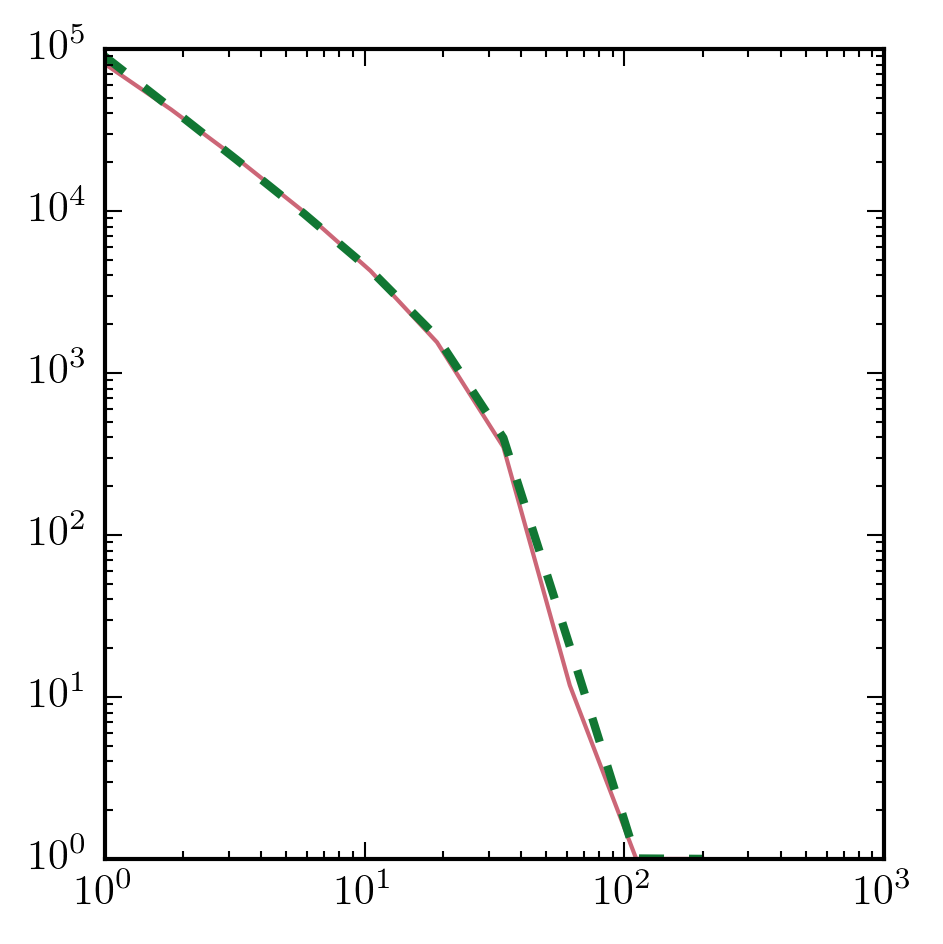

In [86]:
def CLfit(z, params):
    # Super Optimistic
    if params == {'logMcrit': -12, 'Ishiyama': True, 'c_scatter': 0.2, 'cosmo': cosmo, 'subhalos': True}:
        return 1.0+1.4e6*z**-1.3*np.exp(-(z/45)**2.3)
    
    # Pessimistic
    if params == {'logMcrit': -3, 'Ishiyama': False, 'c_scatter': 0.10, 'cosmo': cosmo, 'subhalos': False}:
        return 1.0+1.2e4*z**-1.15*np.exp(-(z/24)**2.0)    
    if params == {'logMcrit': -6, 'Ishiyama': False, 'c_scatter': 0.10, 'cosmo': cosmo, 'subhalos': False}:
        return 1.0+4.0e4*z**-1.15*np.exp(-(z/34)**2.0)
    
    # Realistic
    if params == {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}:
        return 1.0+5.0e5*z**-1.25*np.exp(-(z/40)**2.3)
    if params == {'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}:
        return 1.0+9e4*z**-1.25*np.exp(-(z/34)**2.0)
    
    # Change c_scatter
    if params == {'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0.20, 'cosmo': cosmo, 'subhalos': True}:
        return 1.0+1.0e5*z**-1.25*np.exp(-(z/34)**2.0)
    if params == {'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0.10, 'cosmo': cosmo, 'subhalos': True}:
        return 1.0+7.5e4*z**-1.25*np.exp(-(z/34)**2.0)
    
    # Change Mcrit
    if params == {'logMcrit': -3, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}:
        return 1.0+1.7e4*z**-1.2*np.exp(-(z/24)**2.2)
    if params == {'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}:
        return 1.0+8.5e4*z**-1.25*np.exp(-(z/34)**2.2)
    if params == {'logMcrit': -12, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}:
        return 1.0+1.0e6*z**-1.25*np.exp(-(z/40)**2.05)
    
    # Change subahalo
    if params == {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': False}:
        return 1.0+2.5e5*z**-1.18*np.exp(-(z/40)**2.3)
    
    # Change Ishiyama
    if params == {'logMcrit': -9, 'Ishiyama': False, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}:
        return 1.0+5.0e5*z**-1.25*np.exp(-(z/40)**2.3)
    if params == {'logMcrit': -6, 'Ishiyama': False, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}:
        return 1.0+9e4*z**-1.25*np.exp(-(z/34)**2.0)
    
    
    
    # Other
    if params == {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.2, 'cosmo': cosmo, 'subhalos': False}:
        return 1.0+3.2e5*z**-1.18*np.exp(-(z/40)**2.3)
    if params == {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.10, 'cosmo': cosmo, 'subhalos': True}:
        return 1.0+4.0e5*z**-1.25*np.exp(-(z/40)**2.3)
    if params == {'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': False}:
        return 1.0+5.0e4*z**-1.14*np.exp(-(z/34)**2.2)
    if params == {'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0, 'cosmo': cosmo, 'subhalos': False}:
        return 1.0+3.5e4*z**-1.06*np.exp(-(z/32)**2.0)
    if params == {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.2, 'cosmo': cosmo, 'subhalos': True}:
        return 1.0+6.5e5*z**-1.35*np.exp(-(z/40)**2.3)
    if params == {'logMcrit': -12, 'Ishiyama': True, 'c_scatter': 0.2, 'cosmo': cosmo, 'subhalos': False}:
        return 1.0+6.3e5*z**-1.20*np.exp(-(z/45)**2.3)
    

plt.plot(z_list, B_list+1, '-', lw=1)
plt.plot(z_list, CLfit(z_list, params), '--')
plt.xscale('log')
plt.yscale('log')

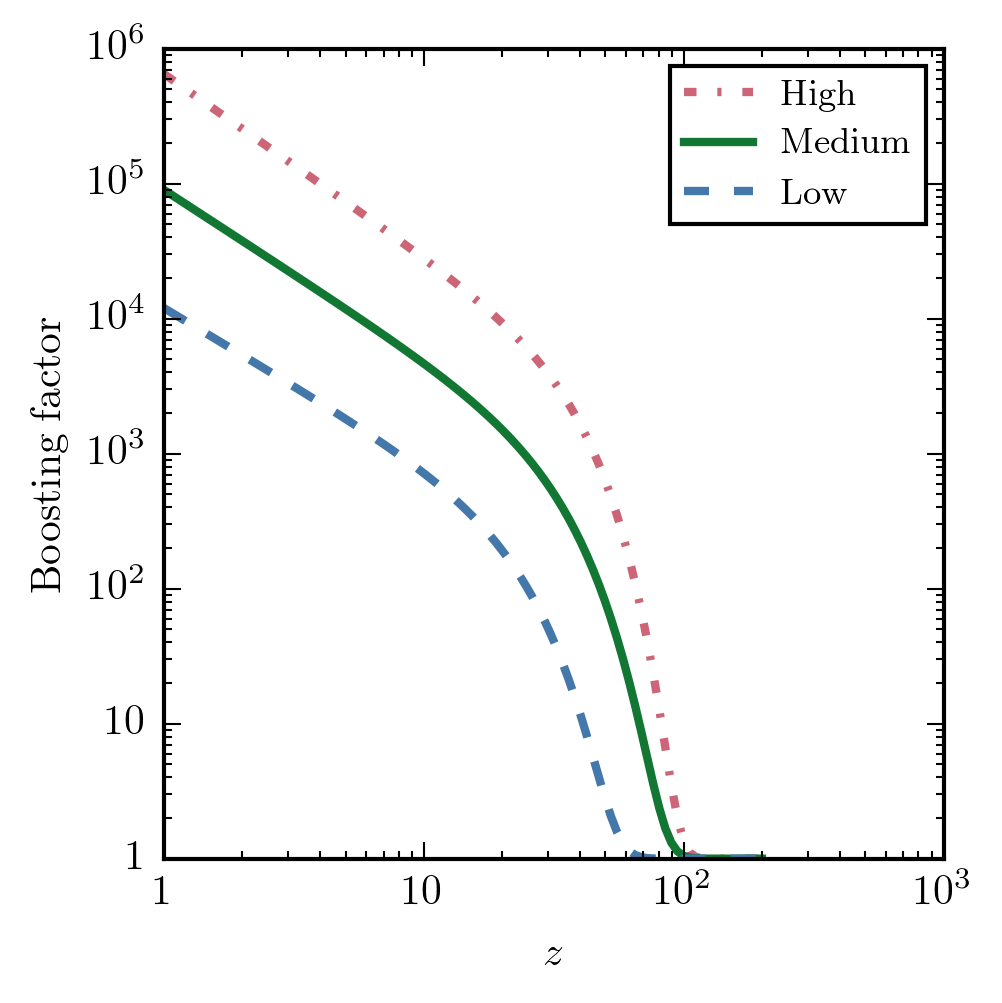

In [33]:
# Vary Mcrit
z_list = np.logspace(0, np.log10(200), 100)
params =  {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.2, 'cosmo': cosmo, 'subhalos': True}
plt.plot(z_list, CLfit(z_list, params), '-.', label=r'$\mathrm{High}$')
params =  {'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}
plt.plot(z_list, CLfit(z_list, params), '-', label=r'$\mathrm{Medium}$')
params =  {'logMcrit': -3, 'Ishiyama': False, 'c_scatter': 0.10, 'cosmo': cosmo, 'subhalos': False}
plt.plot(z_list, CLfit(z_list, params), '--', label=r'$\mathrm{Low}$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=1)
fixlogax(plt.gca())
fixlogax(plt.gca(), 'y')
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{Boosting\;factor}$')
plt.savefig('extremes.pdf')

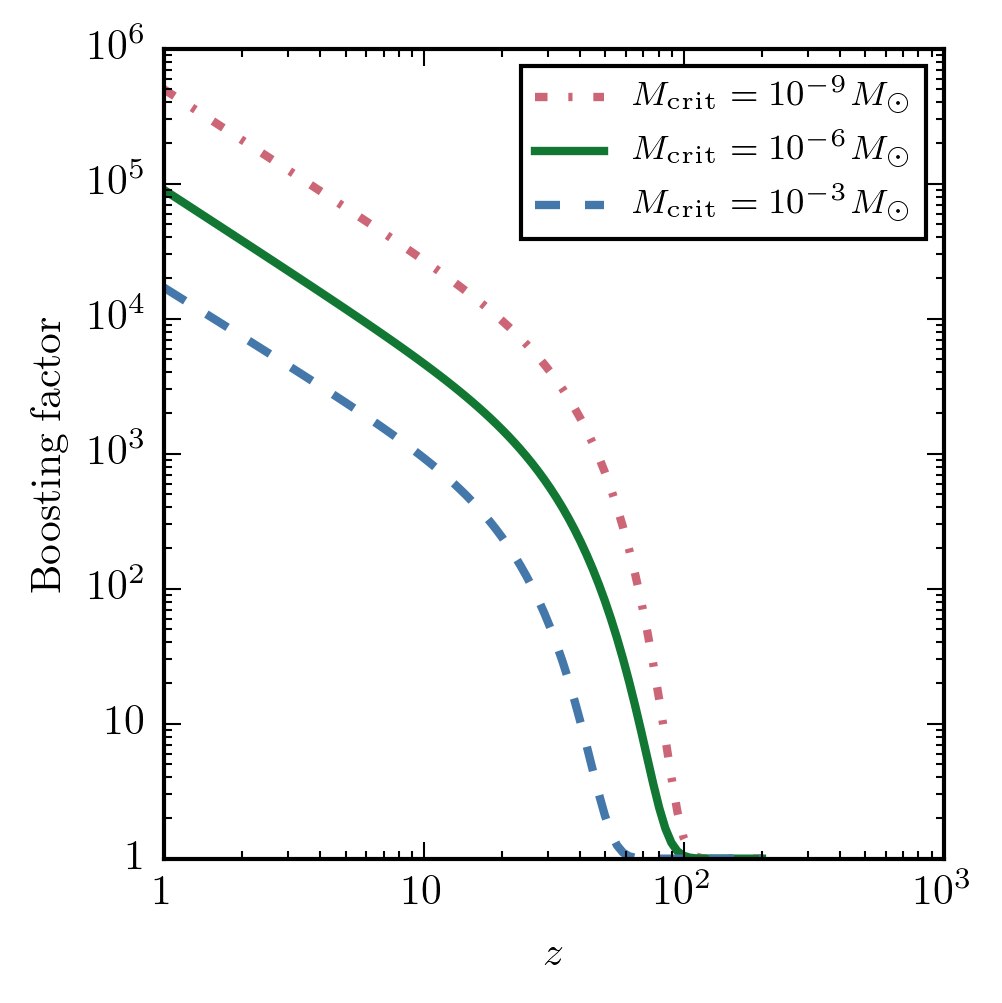

In [48]:
# Vary Mcrit
z_list = np.logspace(0, np.log10(200), 100)
params =  {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}
plt.plot(z_list, CLfit(z_list, params), '-.', label=r'$M_\mathrm{crit}=10^{-9}M_\odot$')
params =  {'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}
plt.plot(z_list, CLfit(z_list, params), '-', label=r'$M_\mathrm{crit}=10^{-6}M_\odot$')
params =  {'logMcrit': -3, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}
plt.plot(z_list, CLfit(z_list, params), '--', label=r'$M_\mathrm{crit}=10^{-3}M_\odot$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=1)
fixlogax(plt.gca())
fixlogax(plt.gca(), 'y')
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{Boosting\;factor}$')
plt.savefig('Mcrit.pdf')

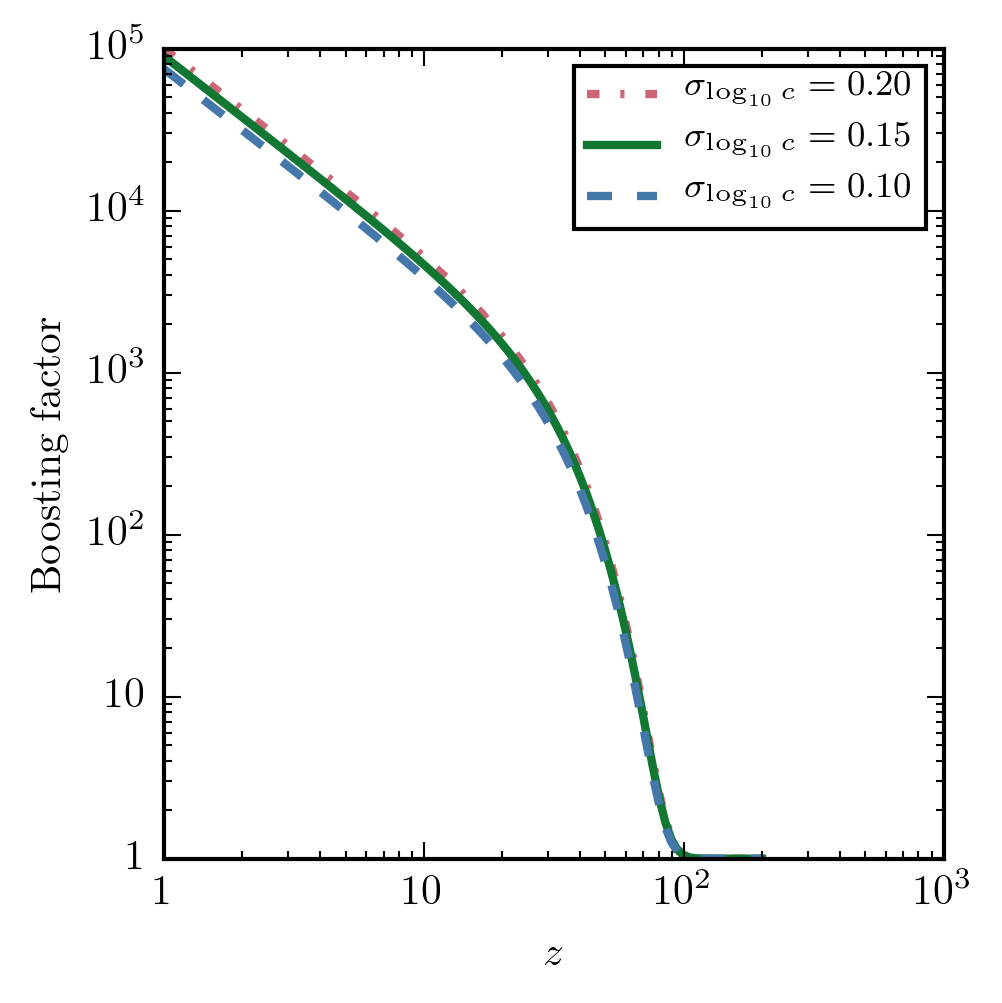

In [81]:
# Vary Mcrit
z_list = np.logspace(0, np.log10(200), 100)
params =  {'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0.20, 'cosmo': cosmo, 'subhalos': True}
plt.plot(z_list, CLfit(z_list, params), '-.', label=r'$\sigma_{\log_{10}c}=0.20$')
params =  {'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}
plt.plot(z_list, CLfit(z_list, params), '-', label=r'$\sigma_{\log_{10}c}=0.15$')
params =  {'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0.10, 'cosmo': cosmo, 'subhalos': True}
plt.plot(z_list, CLfit(z_list, params), '--', label=r'$\sigma_{\log_{10}c}=0.10$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=1)
fixlogax(plt.gca())
fixlogax(plt.gca(), 'y')
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{Boosting\;factor}$')
plt.savefig('c_scatter.pdf')